In [3]:
%load_ext autoreload
%autoreload 2

In [298]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from data_utils import construct_df, ohe_chars_stage, characters, stages, construct_df_igs, process_df_igs
from modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses, validate_model

import xgboost as xgb

In [5]:
gs_5s_ohe=pd.read_pickle('saved_data/gs_5s_ohe.pkl')
fp9_5s_ohe=pd.read_pickle('saved_data/fp9_5s_ohe.pkl')
p2019_5s_ohe=pd.read_pickle('saved_data/p2019_5s_ohe.pkl')
df = pd.concat([gs_5s_ohe, fp9_5s_ohe,p2019_5s_ohe]).reset_index(drop=True)

In [6]:
features = list(df.columns[4:])
features.remove('winner')

## Hardcoded matchups

In [35]:
matchup_df = pd.read_csv('saved_data/matchups.csv', index_col = 'Character')

matchup_df.columns = characters

matchup_df.index = characters

matchup_df/=10

matchup_df = np.clip(matchup_df.T,3,7)
matchup_df-=5
matchup_df

,FOX,FALCO,MARTH,SHEIK,JIGGLYPUFF,PEACH,ICE_CLIMBERS,CAPTAIN_FALCON,PIKACHU,SAMUS,DR_MARIO,YOSHI,LUIGI,GANONDORF,MARIO,YOUNG_LINK,DONKEY_KONG,LINK,GAME_AND_WATCH,ROY,MEWTWO,ZELDA,NESS,PICHU,BOWSER,KIRBY
FOX,0.0,0.0,0.0,-0.5,-0.5,-1.0,-1.5,-0.5,-1.0,-0.5,-1.0,-1.0,-1.5,-2.0,-2.0,-2.0,-1.5,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
FALCO,0.0,0.0,0.0,0.0,0.0,-0.5,-1.0,-1.0,-1.0,0.0,-1.5,-1.0,-1.5,-2.0,-2.0,-2.0,-2.0,-1.5,-2.0,-1.5,-2.0,-2.0,-2.0,-1.5,-2.0,-2.0
MARTH,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,-0.5,-1.0,-1.5,-0.5,-1.5,-1.5,-2.0,-1.5,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.5,-2.0,-2.0
SHEIK,0.5,0.0,0.0,0.0,0.5,-0.5,0.0,-0.5,-1.0,-1.0,-1.5,-1.0,-1.5,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
JIGGLYPUFF,0.5,0.0,0.0,-0.5,0.0,-1.5,-1.0,-0.5,-1.5,-1.5,-1.0,-1.0,-1.0,-1.5,-2.0,-1.0,-2.0,-1.5,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
PEACH,1.0,0.5,1.0,0.5,1.5,0.0,-2.0,1.0,-1.0,-1.0,-1.5,-1.0,-1.0,-1.5,-2.0,-1.5,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
ICE_CLIMBERS,1.5,1.0,1.0,0.0,1.0,2.0,0.0,1.0,-1.0,0.5,-1.0,0.5,1.0,1.0,-1.5,-1.0,-2.0,-2.0,-2.0,-1.0,-2.0,-1.5,-2.0,-2.0,-2.0,-2.0
CAPTAIN_FALCON,0.5,1.0,0.0,0.5,0.5,-1.0,-1.0,0.0,0.0,-2.0,-1.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.5,-2.0,-2.0
PIKACHU,1.0,1.0,0.5,1.0,1.5,1.0,1.0,0.0,0.0,0.0,-0.5,0.5,-0.5,-1.5,-1.0,-1.0,-2.0,-1.5,-2.0,-2.0,-2.0,-2.0,-2.0,-1.5,-2.0,-2.0
SAMUS,0.5,0.0,1.0,1.0,1.5,1.0,-0.5,2.0,0.0,0.0,0.0,-1.0,-0.5,0.5,-1.5,-1.0,-2.0,-0.5,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0


In [38]:
df['p1_char_advantage'] = df.apply(lambda x: matchup_df[x['p1_char']][x['p2_char']], axis=1)

In [47]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

X_train = df_train[features]
y_train = df_train['winner']

X_val = df_val[features]
y_val = df_val['winner']

X_test = df_test[features]
y_test = df_test['winner']

In [50]:
features = list(df.columns[4:])
features.remove('winner')

new_feats = features[:5] + features[-7:]

Training accuracy: 0.986
Training log loss: 0.129
Validation accuracy: 0.802
Validation log loss: 0.424


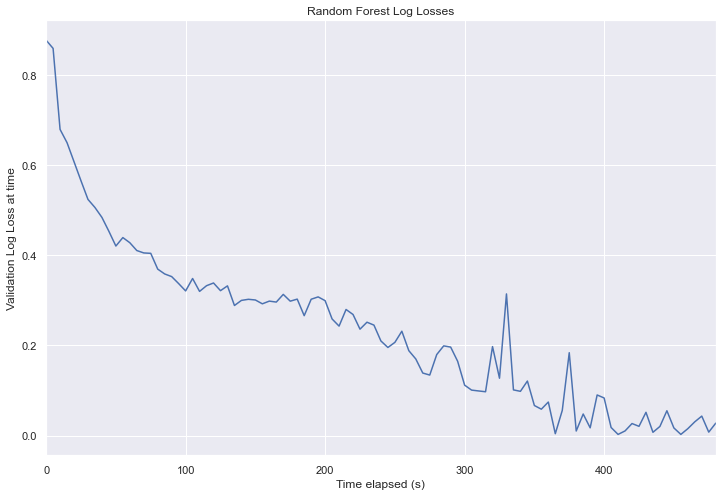

In [57]:
rf = validate_model(RandomForestClassifier(n_estimators =100, n_jobs=-1),
                    X_train, y_train,X_val,y_val, 'Random Forest Log Losses')

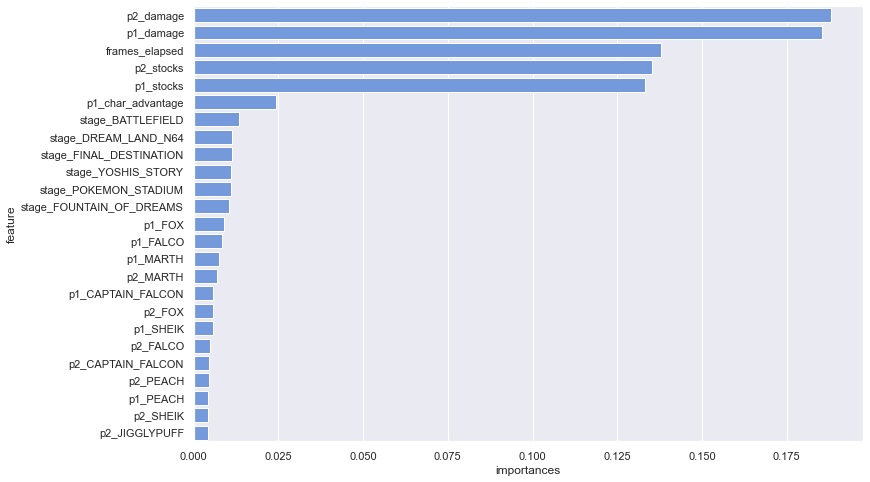

In [58]:
plot_feature_importances(rf, features, 25)

## In game stat-based features

In [233]:
def test_features(feature_list, df, **kwargs):
    
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
    
    X_train = df_train[feature_list]
    y_train = df_train['winner']
    
    X_val = df_val[feature_list]
    y_val = df_val['winner']
    
    model = validate_model(RandomForestClassifier(n_jobs=-1,**kwargs),
                    X_train, y_train,X_val,y_val, 'Random Forest Log Losses')
    
    return model

In [8]:
gs_5s_igs = pd.read_pickle('saved_data/gs_5s_igs.pkl')
fp9_5s_igs=pd.read_pickle('saved_data/fp9_5s_igs.pkl')
df = ohe_chars_stage(pd.concat([gs_5s_igs, fp9_5s_igs]).reset_index(drop=True))

In [9]:
df

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM
0,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,0,4.0,4.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,600.0,5.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,600.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,900.0,7.0,0.0,1.0,2.0,2.0,16.0,0.0,0.0,900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1200,4.0,4.0,95.940002,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1200.0,11.0,1.0,1.0,5.0,2.0,55.0,0.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132930,Game_20190406T175301,SHEIK,CAPTAIN_FALCON,FINAL_DESTINATION,10800,1.0,1.0,18.340000,56.620003,1,46.0,13.0,5.0,7.0,3.0,430.0,4.0,0.0,391.0,32.0,3.0,1.0,22.0,2.0,452.0,13.0,1.0,2531.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
132931,Game_20190406T175301,SHEIK,CAPTAIN_FALCON,FINAL_DESTINATION,11100,1.0,1.0,31.340000,56.620003,1,46.0,13.0,5.0,7.0,3.0,448.0,4.0,0.0,691.0,35.0,6.0,1.0,22.0,2.0,491.0,14.0,1.0,2831.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [10]:
features = list(df.columns[4:])
features.remove('winner')
basic_features = features[:5]
basic_ohe = features[:5] + features[23:]
basic_igs = features[:23]


#X_train = df_train[features]
#y_train = df_train['winner']
#
#X_val = df_val[features]
#y_val = df_val['winner']
#
#X_test = df_test[features]
#y_test = df_test['winner']

### Baseline features 

Training accuracy: 0.964
Training log loss: 0.172
Validation accuracy: 0.720
Validation log loss: 0.686


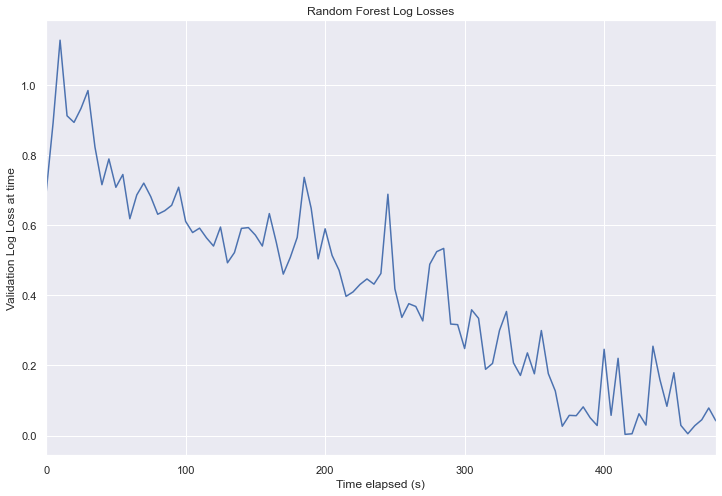

In [234]:
rf_basic_only=test_features(basic_features, df)

### Basic features and OHE characters and stage

Training accuracy: 0.986
Training log loss: 0.130
Validation accuracy: 0.801
Validation log loss: 0.425


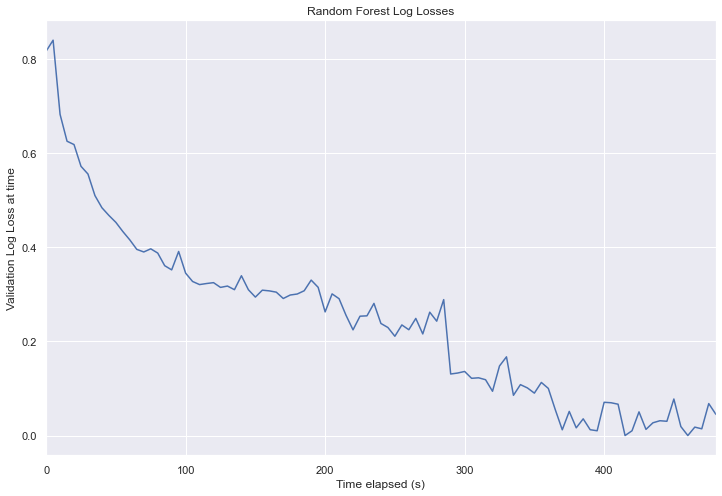

In [235]:
rf_basic_and_ohe=test_features(basic_ohe, df)

### Basic features and ingame stats 

Training accuracy: 0.982
Training log loss: 0.131
Validation accuracy: 0.832
Validation log loss: 0.384


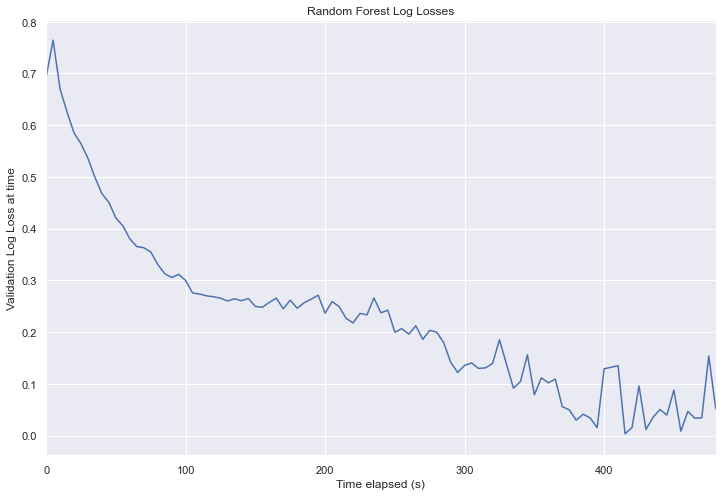

In [236]:
rf_basic_and_igs=test_features(basic_igs, df)

Exciting! This performs similarly to the model that uses the ohe categories, and it starts with a lower loss

### Basic features, OHE characters and stages, ingame stats 

Training accuracy: 0.989
Training log loss: 0.119
Validation accuracy: 0.863
Validation log loss: 0.353


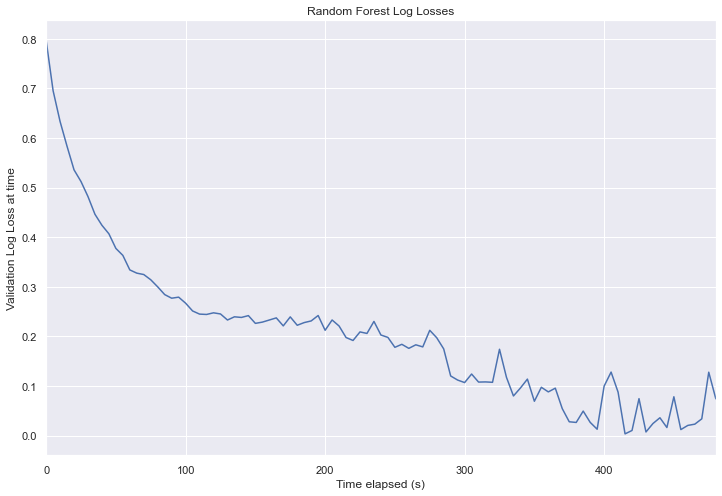

In [237]:
rf_basic_ohe_igs=test_features(features, df)

Performs better than the previous models, if only by a bit. Looks like the beginning is a bit worse again though, but it seems less noisy at the end.

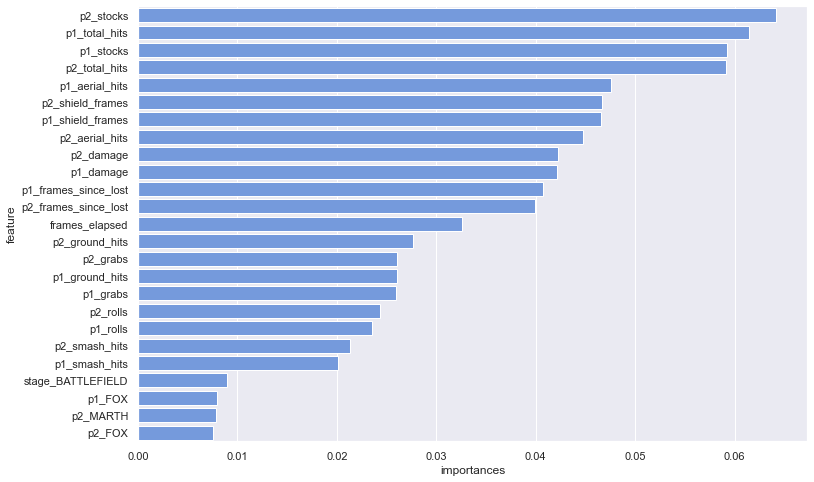

In [17]:
plot_feature_importances(rf_basic_ohe_igs, features, 25)

Looking at the feature importances, it really seems like these in game stats are more important than the ohe columns. Total hits being at the top makes sense, but I'm surprised that sheid frames are up there too.

## Composite features 

Instead of letting the model find the relationships between the p1 and p2 stats, lets try making some columns that more directly bring in their comparison

### Difference features

In [217]:
p2019_5s_igs = pd.read_pickle('saved_data/p2019_5s_igs.pkl')

df = ohe_chars_stage(pd.concat([gs_5s_igs, fp9_5s_igs,p2019_5s_igs]).reset_index(drop=True))
df['hit_diff'] = (df['p1_total_hits'] - df['p2_total_hits'])
df['shield_diff'] = df['p1_shield_frames']-df['p2_shield_frames']
df['early_stock_diff'] = df['p1_early_stocks_lost'] - df['p2_early_stocks_lost']
df

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff
0,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,0,4.0,4.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,600.0,5.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,600.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.0,8.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,900.0,7.0,0.0,1.0,2.0,2.0,16.0,0.0,0.0,900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-7.0,-8.0,0.0
4,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1200,4.0,4.0,95.940002,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1200.0,11.0,1.0,1.0,5.0,2.0,55.0,0.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-11.0,-47.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423983,Game_20190421T135159,FOX,FALCO,POKEMON_STADIUM,6900,1.0,2.0,0.000000,0.0,0,45.0,4.0,1.0,15.0,4.0,234.0,0.0,0.0,709.0,37.0,5.0,0.0,21.0,0.0,241.0,3.0,0.0,67.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,-7.0,0.0
423984,Game_20190421T135159,FOX,FALCO,POKEMON_STADIUM,7200,1.0,2.0,20.000000,0.0,0,45.0,4.0,1.0,15.0,4.0,234.0,0.0,0.0,1009.0,39.0,5.0,0.0,22.0,0.0,241.0,3.0,0.0,367.0,1.0,0.0

In [218]:
new_feats = features + ['hit_diff','shield_diff','early_stock_diff']
removed_feats = ['p1_total_hits','p2_total_hits','p1_shield_frames','p2_shield_frames',
                 'p1_early_stocks_lost','p2_early_stocks_lost']
new_feats_rem = [f for f in new_feats if f not in removed_feats]

Training accuracy: 0.989
Training log loss: 0.118
Validation accuracy: 0.867
Validation log loss: 0.350


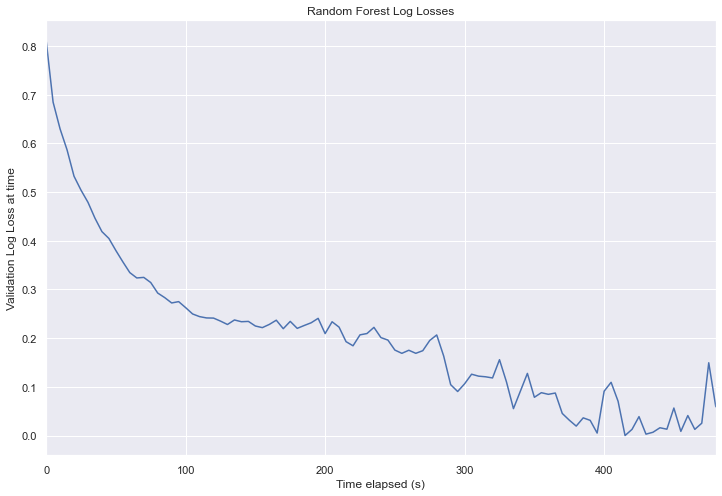

In [231]:
rf_diff1=test_features(new_feats, df)

Training accuracy: 0.989
Training log loss: 0.117
Validation accuracy: 0.871
Validation log loss: 0.347


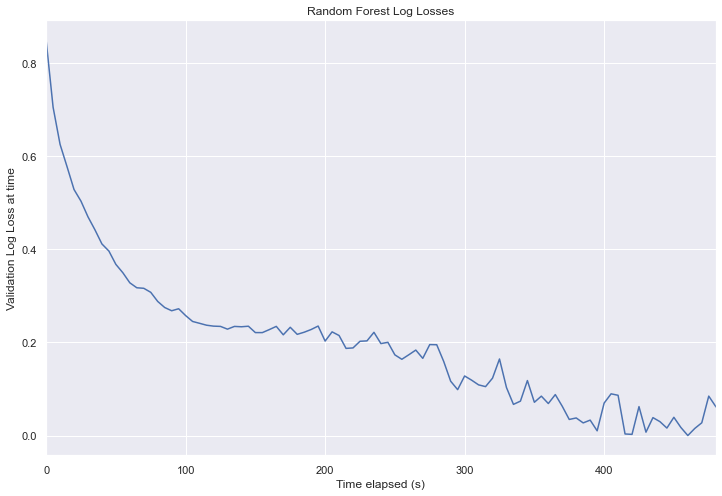

In [232]:
rf_diff1_rem=test_features(new_feats_rem, df)

Another slight improvement, with removing the features used in the differences giving a slight advantage

### More difference features 

In [221]:
df['ground_diff'] = df['p1_ground_hits'] - df['p2_ground_hits']
df['smash_diff'] = df['p1_smash_hits']-df['p2_aerial_hits']
df['aerial_diff'] = df['p1_aerial_hits'] - df['p1_aerial_hits']
df['grab_diff'] = df['p1_grabs'] - df['p2_grabs']
df['roll_diff'] = df['p1_rolls']-df['p2_rolls']
df['stock_diff_sc'] = df['p1_stocks']**4 - df['p2_stocks']**4
df.head(20)

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff,ground_diff,smash_diff,aerial_diff,grab_diff,roll_diff,stock_diff_sc
0,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,0,4.0,4.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,600.0,5.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,600.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.0,8.0,0.0,0.0,0.0,0.0,-2.0,1.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,900.0,7.0,0.0,1.0,2.0,2.0,16.0,0.0,0.0,900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-7.0,-8.0,0.0,0.0,-2.0,0.0,-2.0,1.0,0.0
4,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1200,4.0,4.0,95.940002,0.000000,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1200.0,11.0,1.0,1.0,5.0,2.0,55.0,0.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-11.0,-47.0,0.0,-1.0,-5.0,0.0,-2.0,1.0,0.0
5,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1500,4.0,4.0,119.169998,0.000000,0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,0.0,1500.0,14.0,1.0,1.0,8.0,2.0,55.0,0.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-14.0,-23.0,0.0,-1.0,-8.0,0.0,-2.0,1.0,0.0
6,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1800,4.0,4.0,146.479996,0.000000,0,0.0,0.0,0.0,0.0,0.0,34.0,1.0,0.0,1800.0,17.0,2.0,1.0,10.0,2.0,55.0,0.0,0.0,1800.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [222]:
new_feats2 = new_feats + ['ground_diff', 'smash_diff', 'aerial_diff', 'grab_diff', 'roll_diff','stock_diff_sc']
removed_feats2 = removed_feats + ['p1_ground_hits', 'p1_smash_hits', 'p1_aerial_hits', 'p1_grabs','p1_rolls',
                 'p2_ground_hits', 'p2_smash_hits', 'p2_aerial_hits', 'p2_grabs','p2_rolls']
new_feats_rem2 = [f for f in new_feats2 if f not in removed_feats2]

Training accuracy: 0.989
Training log loss: 0.115
Validation accuracy: 0.866
Validation log loss: 0.345


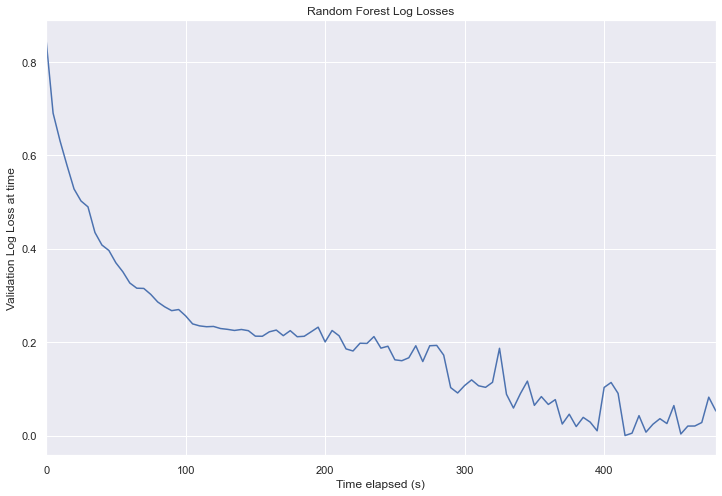

In [238]:
rf_diff2=test_features(new_feats2, df)

Training accuracy: 0.988
Training log loss: 0.121
Validation accuracy: 0.844
Validation log loss: 0.369


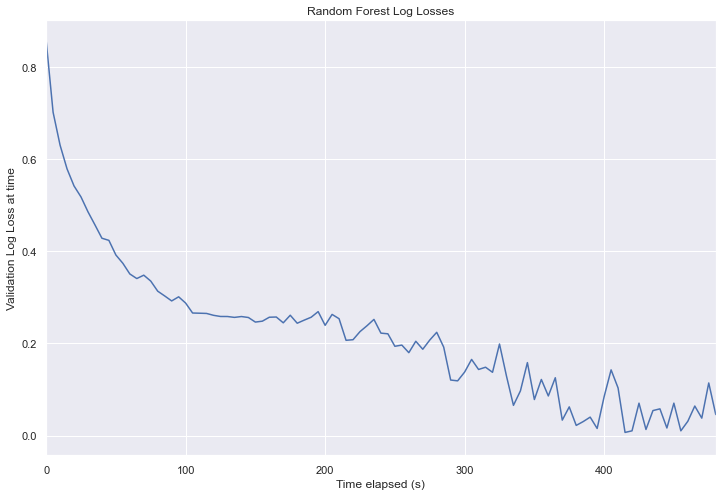

In [239]:
rf_diff2_rem=test_features(new_feats_rem2, df)

Looks like leaving everything in is the best for now. I want to try removing only player 2 information. P1 information + the difference should encode the same information, but now its from the perspective of p1 only

In [168]:
p2_feats = ['p2_total_hits', 'p2_ground_hits','p2_smash_hits','p2_aerial_hits','p2_grabs','p2_shield_frames','p2_rolls','p2_early_stocks_lost']

In [169]:
p1_diff_feats = [f for f in new_feats2 if f not in p2_feats]

Training accuracy: 0.989
Training log loss: 0.117
Validation accuracy: 0.858
Validation log loss: 0.353


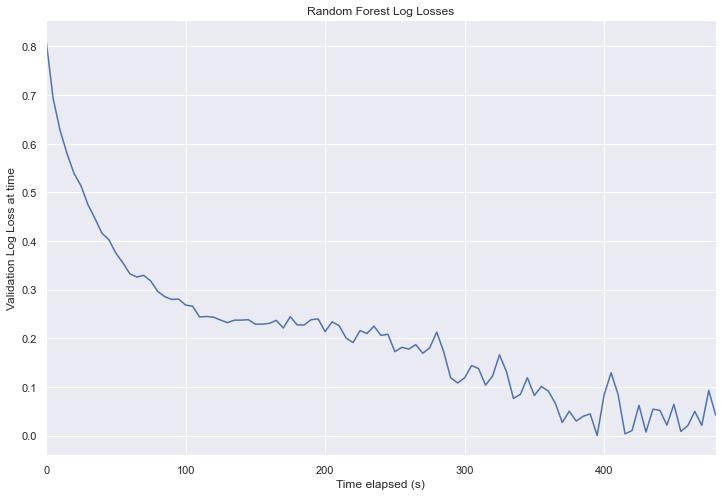

In [240]:
rf_p1_diff=test_features(p1_diff_feats, df)

Slightly worse than having all the features in, but really the differences are negligible 

## Final RF model

I put a function called process_df_igs that takes the output from construct_df_igs and puts these features in then one-hot encodes them. Going to try one final model to see if I can get lower LL.

Training accuracy: 0.989
Training log loss: 0.112
Validation accuracy: 0.885
Validation log loss: 0.325


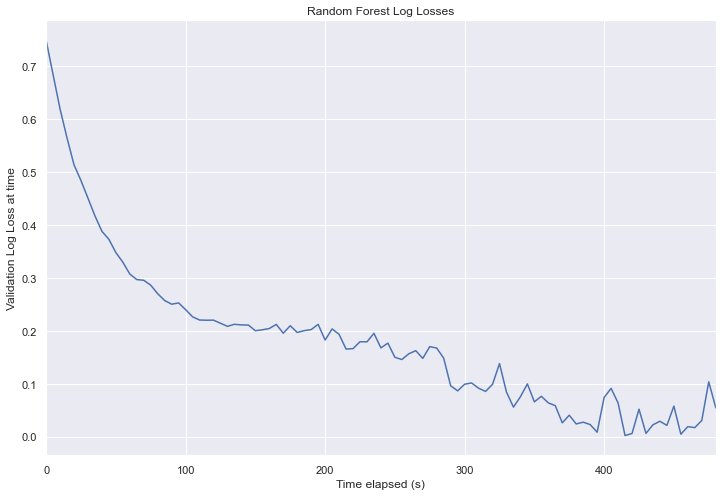

In [303]:
rf_final=test_features(new_feats2, df, n_estimators=1000,max_features=5)

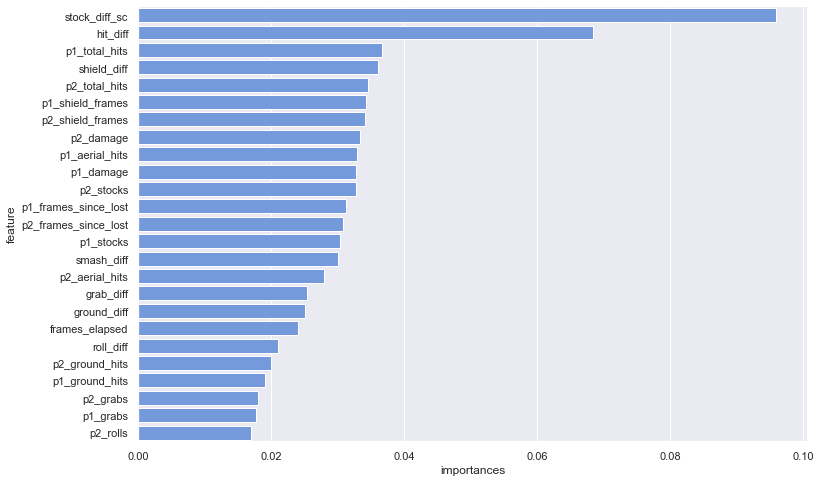

In [304]:
plot_feature_importances(rf_final, new_feats2, 25)

Games parsed: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


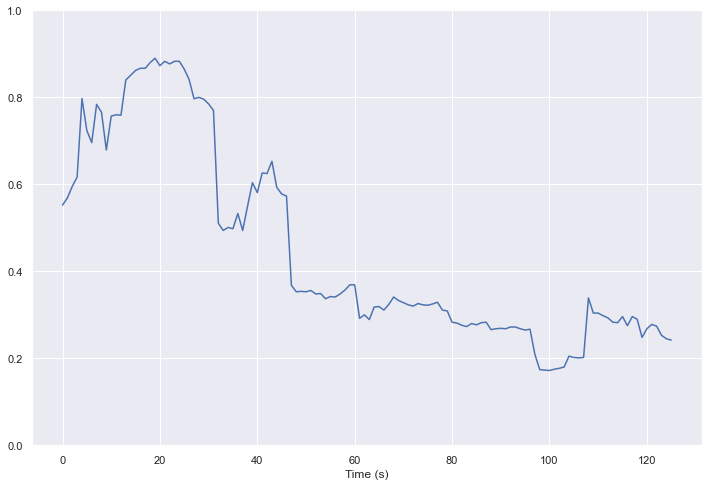

In [305]:
prob_check = construct_df_igs(['replays/mangozain.slp'],1)
prob_check,all_diff_feats = process_df_igs(prob_check)
plot_win_probs(prob_check,rf_final, all_diff_feats)

Games parsed: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


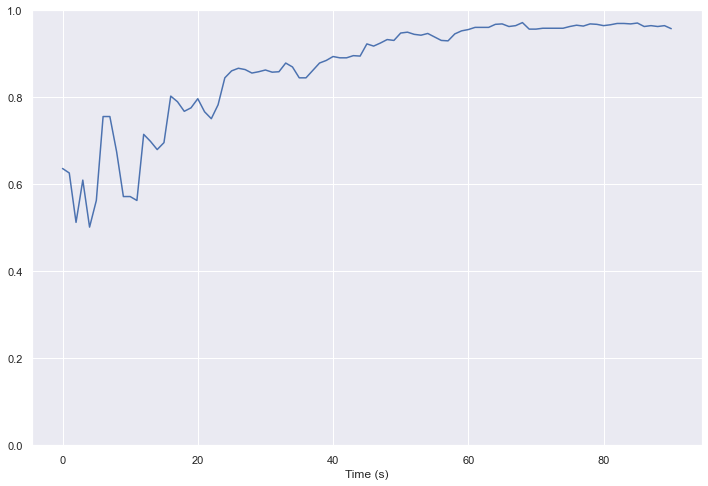

In [306]:
prob_check = construct_df_igs(['replays/4stockp1.slp'],1)
prob_check,all_diff_feats = process_df_igs(prob_check)
plot_win_probs(prob_check,rf_final, all_diff_feats)

Games parsed: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


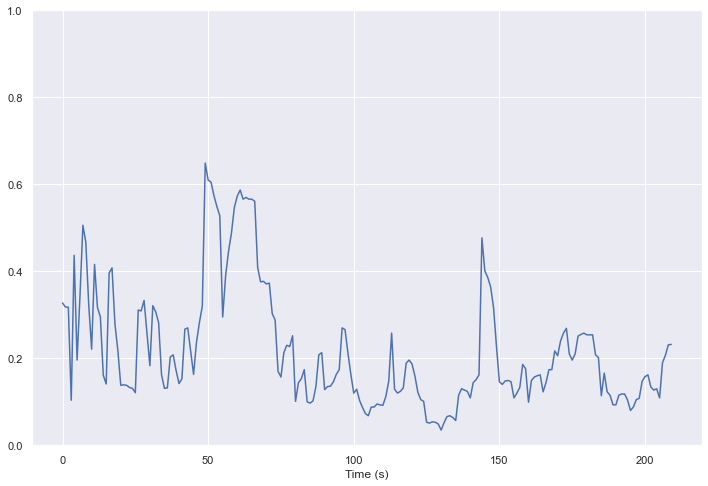

In [307]:
prob_check = construct_df_igs(['replays/test.slp'],1)
prob_check,all_diff_feats = process_df_igs(prob_check)
plot_win_probs(prob_check,rf_final, all_diff_feats)

I think these graphs make some sense. In the first game p1 takes a quick stock then proceeds to steadily lose. The second is a 4 stock so the win probability pretty steadily goes up. The last one is a bit concerning because it seems pretty close, but maybe the model is picking up on the fact that as floaties live a long time fast fallers like falcon get flustered and are less likely to win. 

In [308]:
df

,id,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_total_hits,p1_ground_hits,p1_smash_hits,p1_aerial_hits,p1_grabs,p1_shield_frames,p1_rolls,p1_early_stocks_lost,p1_frames_since_lost,p2_total_hits,p2_ground_hits,p2_smash_hits,p2_aerial_hits,p2_grabs,p2_shield_frames,p2_rolls,p2_early_stocks_lost,p2_frames_since_lost,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM,hit_diff,shield_diff,early_stock_diff,ground_diff,smash_diff,aerial_diff,grab_diff,roll_diff,stock_diff_sc
0,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,0,4.0,4.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,300,4.0,4.0,0.000000,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,600,4.0,4.0,27.440001,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,600.0,5.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,600.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.0,8.0,0.0,0.0,0.0,0.0,-2.0,1.0,0.0
3,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,900,4.0,4.0,52.270004,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,900.0,7.0,0.0,1.0,2.0,2.0,16.0,0.0,0.0,900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-7.0,-8.0,0.0,0.0,-2.0,0.0,-2.0,1.0,0.0
4,Game_20190309T134133,FOX,MARTH,BATTLEFIELD,1200,4.0,4.0,95.940002,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1200.0,11.0,1.0,1.0,5.0,2.0,55.0,0.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-11.0,-47.0,0.0,-1.0,-5.0,0.0,-2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423983,Game_20190421T135159,FOX,FALCO,POKEMON_STADIUM,6900,1.0,2.0,0.000000,0.0,0,45.0,4.0,1.0,15.0,4.0,234.0,0.0,0.0,709.0,37.0,5.0,0.0,21.0,0.0,241.0,3.0,0.0,67.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0